# Nested sampling
### Demonstrating the nested sampling method via integrating a 2D function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import warnings 
warnings.filterwarnings("ignore")
import time
from IPython import display

The 2D function to sample. (Sum of three Gaussians, with our range of interest being [0.0:10.0] both in x and y directions.)

The example is analogous to sampling materials' PES: starting from "high energy" and going towards the global minimum. 

In [2]:
def function_2D(x,y):
    """the function of which integrand we want to find this is a 2D function, with three gaussians"""
    f=-np.exp(-0.2*(x-3)**2-0.2*(y-5)**2) - 0.9*np.exp(-0.5*(x-7)**2-0.5*(y-7)**2) - 0.6*np.exp(-(x-5)**2-(y-3)**2)
    
    return f

x_limits=[0,10] # x range
y_limits=[0,10] # y range
Exact = -22.755  # Exact integral value of this 2D function within the above x and y limits

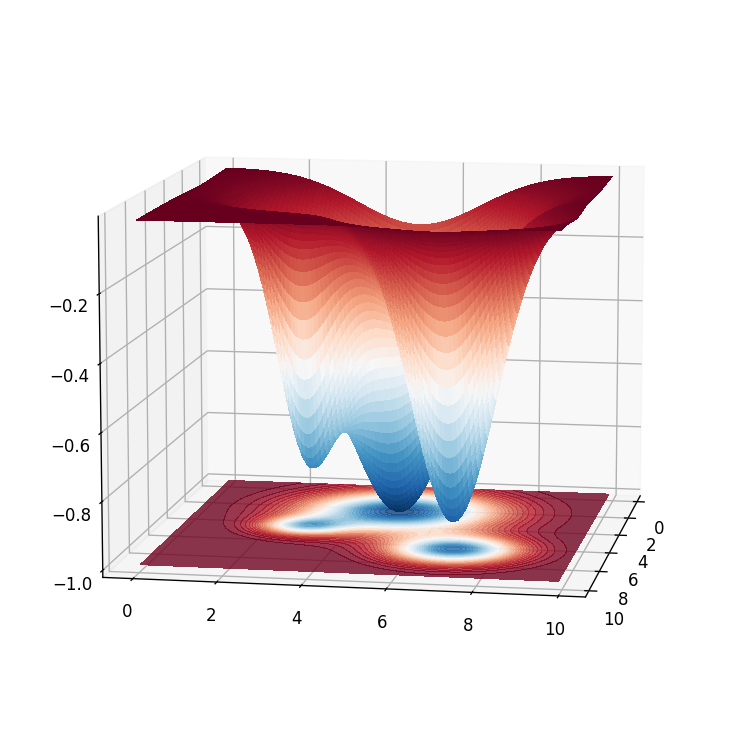

In [3]:
x = np.arange(x_limits[0],x_limits[1],0.1)
y = np.arange(y_limits[0],y_limits[1],0.1)
X,Y = np.meshgrid(x, y)
Z = function_2D(X, Y) # evaluation of the function on the grid

fig = plt.figure(figsize=(8,8), dpi=120)
ax = fig.gca(projection='3d')
ax.view_init(elev=10., azim=10)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu_r, linewidth=0, antialiased=False)
cset = ax.contourf(X, Y, Z, zdir='z', offset=np.min(Z), cmap=cm.RdBu_r, alpha=0.8,levels=40)
    
plt.show()

### Nested sampling algorithm

In [4]:
def generate_random_point(x_limits,y_limits):

    x = np.random.uniform(x_limits[0],x_limits[1])
    y = np.random.uniform(y_limits[0],y_limits[1])

    f=function_2D(x,y)
    
    return ([x,y],f)

In [5]:
def create_walkers(n_walkers,x_limits,y_limits):
    """create the initial set of walkers = choose a number of uniformly random points in the range we want to study """
    walkers=[] # walkers' "coordinates"
    likelihood=[] # likelihood value of walkers
    
    for i in range(n_walkers):
        
        ([x,y],f) = generate_random_point(x_limits,y_limits)
        
        walkers.append([x,y])
        likelihood.append(f)
        #print(i,'-th walker created, with likelihood:', f)
    
    walkers=np.array(walkers)
    
    return (walkers,likelihood)

In [16]:
def random_walk(coordinates,stepsize,n_steps,E_limit):
    
    accepted=0
    for i in range(n_steps):
        rnd = (np.random.rand(2)-0.5)*stepsize
        coord_temp=coordinates+rnd
        E = function_2D(coord_temp[0],coord_temp[1])
        if E<E_limit:
            coordinates=coord_temp
            accepted=accepted+1
    acc_ratio=float(accepted)/n_steps     
    return(coordinates,acc_ratio)        

In [207]:
def plot_walkers(X,Y,Z,x_limits,y_limits,walkers,rejected,walk,index_max,ns_iter,E_limit):
    plt.close()
    display.clear_output(wait=True)
    fig = plt.figure(figsize=(6,6), dpi=100)
    plt.contourf(X,Y,Z,levels=40,cmap=cm.RdBu_r,alpha=0.8)
    plt.plot(walkers[:,0],walkers[:,1],".",color='k')
    plt.plot(walkers[index_max,0],walkers[index_max,1],"o",color='lime') # highest energy point among the initial walkers
    if rejected is not None:
        plt.plot(rejected[:,0],rejected[:,1],'-',color="red")
    if walk is not None:    
        plt.plot(walk[:,0],walk[:,1],'-',color="yellow")
    plt.xlim(0,x_limits[1])
    plt.ylim(0,y_limits[1])
    plt.text(6,1,"NS iteration: "+str(ns_iter),color="white")
    plt.text(6,0.5,"Highest energy: "+str(E_limit),color="white")
    plt.draw()
    time.sleep(0.1)
    plt.pause(0.0001)         

### Nested sampling parameters

In [215]:
n_walkers = 100      # number of walkers, i.e. size of the live set
ns_iterations = 1200 # number of NS iterations to reach convergence (=all walkers near the maximum likelihood)
                     # the more walkers, the more iterations will be needed
    
# Area and NS weight to be used for the integral
Area = (x_limits[1]-x_limits[0])*(y_limits[1]-y_limits[0])
alpha = n_walkers / (n_walkers+1) # nested sampling weight = K/(K+1)
Integral = 0.0     

### Initial configurations generated 

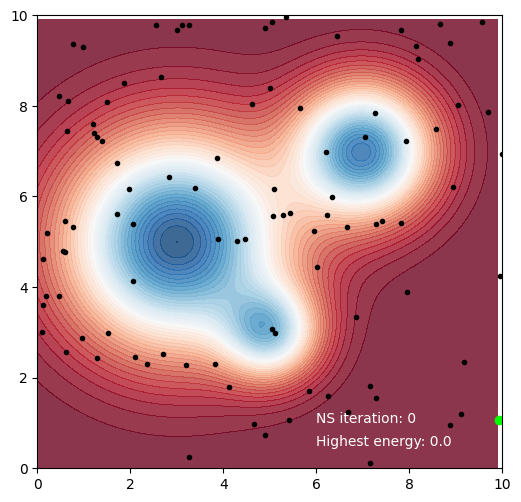

In [216]:
# Create all walkers and plot them.
(walkers,energy)=create_walkers(n_walkers=n_walkers,x_limits=x_limits,y_limits=y_limits)

index_max = np.argmax(energy)
plot_walkers(X,Y,Z,x_limits,y_limits,walkers,None,None,index_max,0,0.0)

#### How to generate a new configuration? 

##### Random pick:
We generate a new point by drawing uniform x,y pairs in the entire range until we find one
which has a lower energy (larger likelihood) than the current limit. The downside of this is that in more complex cases, in high-dimensional functions, or where the basins/peaks get narrower much more quickly, it becomes quickly unaffordable to choose successful candidate points randomly. 
            
##### Random walk:    
We clone a randomly chosen existing walker (point) and perform a random walk: propose random steps, accepted if the energy remains below the current limit, otherwise rejected, until our point becomes "independent" of the starting point. This will be our new walker.

In [203]:
# do random walk (or if False, do the 'random pick')
do_walk=False
n_walk_steps = 1000 
stepsize=5.0 # initial stepsize (this is adjusted on the go to achieve acceptance ratio > 20% )

# if doing just random points 
max_trial = 10000 # max random trials for generating new point - avoid getting into an infinite cycle

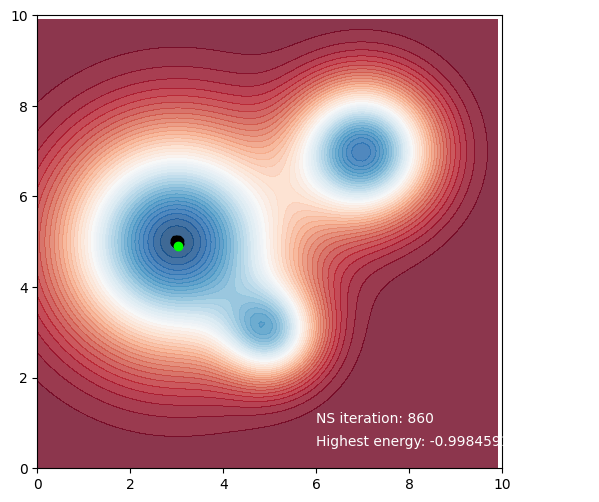

Could not find acceptable point within 10000 trials. STOP.
NS is done
Exact integral: -22.755 , NS_integral= -22.557440599208263 ( 99.13179784314772 % )


In [217]:
# Start nested sampling iteration
for ns_iter in range(ns_iterations):

    index_max = np.argmax(energy) # find point with highest energy (lowest likelihood)
    E_limit = energy[index_max]   # this is the current highest-limit for energy
    Integral += (alpha**(ns_iter-1) - alpha**ns_iter) * E_limit * Area # update integral
    
    if (np.mod(ns_iter,10)==0): # keep track of how far we got in the sampling
        plot_walkers(X,Y,Z,x_limits,y_limits,walkers,None,None,index_max,ns_iter,E_limit)
    if ns_iter==250: # save walkers for demonstration
        walkers_saved = walkers*1.0
        elimit_saved = E_limit
        stepsize_saved = stepsize
            
    # generate new point which has lower energy (higher likelihood) than the current limit 
    if (do_walk): # do a walk
        i_walker=np.random.randint(n_walkers)
        new_point,acc_ratio=random_walk([walkers[i_walker,0],walkers[i_walker,1]],stepsize,n_walk_steps,E_limit)
        walkers[index_max]=new_point
        if (np.mod(ns_iter,10)==0 and acc_ratio<0.2): # check if stepsize needs updating
                stepsize=stepsize*0.8
        energy[index_max]=function_2D(new_point[0],new_point[1])
    else:  # try to randomly choose an acceptable point 
        i_trial=0
        E_new=E_limit+1.0
        while E_new > E_limit and i_trial < max_trial:
            ([x,y],E_new) = generate_random_point(x_limits,y_limits)
            i_trial = i_trial+1

        if i_trial == max_trial :
            print('Could not find acceptable point within',max_trial,'trials. STOP.')
            break
        else:    
            # update 'worst' walker with the new point
            walkers[index_max]=[x,y]
            energy[index_max]=E_new

print("NS is done")
print('Exact integral:',Exact,', NS_integral=',Integral, '(', (Integral/Exact)*100, '% )')        

### Demonstrating a random walk

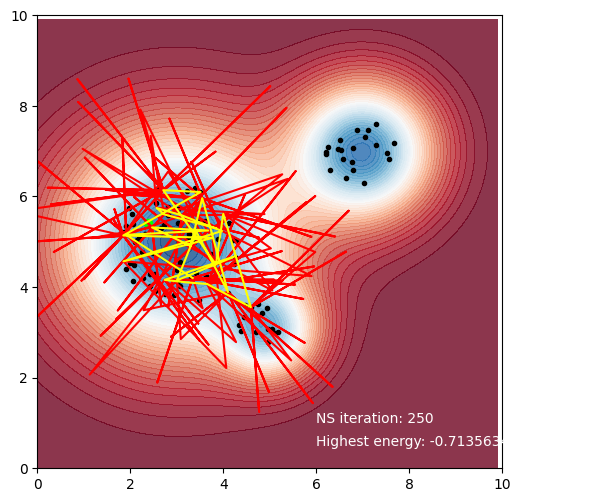

In [229]:
# Demonstrate random walk starting from a random walker
i_point=np.random.randint(100)
walk = np.array([walkers_saved[i_point,0],walkers_saved[i_point,1]])
new_point = walk*1.0
walk = np.concatenate(([walk],[walk]))
rejected = walk*1.0
for i in range(100):
    rnd = (np.random.rand(2)-0.5)*stepsize_saved
    #rnd = (np.random.rand(2)-0.5)*0.5
    temp_point=new_point+rnd
    E = function_2D(temp_point[0],temp_point[1])
    
    if E<elimit_saved: # accept step
        new_point=temp_point*1.0
        walk=np.concatenate((walk,[temp_point]),axis=0)
        
    else: # reject step
        rejected=np.concatenate((rejected, [temp_point]),axis=0)
        rejected=np.concatenate((rejected, [new_point]),axis=0)
    #yellow lines represent the walk, red lines are rejected trial steps
    plot_walkers(X,Y,Z,x_limits,y_limits,walkers_saved,rejected,walk,index_max,250,elimit_saved)    
    